In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns


In [16]:
import os
from torchvision import datasets
import torchvision.transforms as transforms
import torch
import numpy as np
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

batch_size = 64
num_workers = 0

data_dir = 'dogImages/'
train_dir = os.path.join(data_dir, 'train/')
valid_dir = os.path.join(data_dir, 'valid/')
test_dir = os.path.join(data_dir, 'test/')

standard_normalization = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])


data_transforms = {'train': transforms.Compose([transforms.RandomResizedCrop(224),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.RandomAffine(30, translate=(0.2, 0.2), scale=(0.5, 1.5), shear=0.2),
                                     transforms.ToTensor(),
                                     standard_normalization]),
                   'val': transforms.Compose([transforms.Resize(256),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     standard_normalization]),
                   'test': transforms.Compose([transforms.Resize(size=(224,224)),
                                     transforms.ToTensor(), 
                                     standard_normalization])
                  }

In [17]:
train_data = datasets.ImageFolder(train_dir, transform=data_transforms['train'])
valid_data = datasets.ImageFolder(valid_dir, transform=data_transforms['val'])
test_data = datasets.ImageFolder(test_dir, transform=data_transforms['test'])

In [18]:
train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=batch_size, 
                                           num_workers=num_workers,
                                           shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data,
                                           batch_size=batch_size, 
                                           num_workers=num_workers,
                                           shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data,
                                           batch_size=batch_size, 
                                           num_workers=num_workers,
                                           shuffle=False)
loaders_scratch = {
    'train': train_loader,
    'valid': valid_loader,
    'test': test_loader
}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(224, 224, 3)


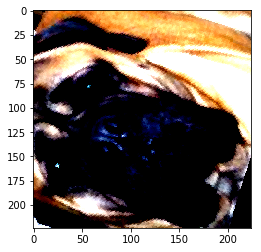

In [144]:
import matplotlib.image as mpimg
img = np.array([])
for batch_idx, (data, target) in enumerate(loaders_scratch['train']):
    img = np.transpose(data[0].numpy())
    print(img.shape)
    plt.imshow(img)
    break

In [145]:
import scipy.misc
scipy.misc.imsave('test4.jpg', img)

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:2: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  from ipykernel import kernelapp as app


In [43]:
import torchvision.models as models
import torch.nn as nn
use_cuda = True
## TODO: Specify model architecture 
model_transfer = models.resnet101(pretrained=True)

if use_cuda:
    model_transfer = model_transfer.cuda()

In [44]:
for param in model_transfer.parameters():
    param.requires_grad = False
model_transfer.fc = nn.Linear(2048, 133, bias=True)
fc_parameters = model_transfer.fc.parameters()
for param in fc_parameters:
    param.requires_grad = True
if use_cuda:
    model_transfer = model_transfer.cuda()

In [45]:
# import torch
# import torch.optim as optim

# criterion_transfer = torch.nn.CrossEntropyLoss()
# optimizer_transfer = optim.SGD(model_transfer.fc.parameters(), lr=0.005)
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

<All keys matched successfully>

In [36]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))

            # initialize weights to zero
            optimizer.zero_grad()
            
            output = model(data)
            
            # calculate loss
            loss = criterion(output, target)
            
            # back prop
            loss.backward()
            
            # grad
            optimizer.step()
            
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
            if batch_idx % 100 == 0:
                print('Epoch %d, Batch %d loss: %.6f' %
                  (epoch, batch_idx + 1, train_loss))
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output = model(data)
            loss = criterion(output, target)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))

            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            torch.save(model.state_dict(), save_path)
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            valid_loss_min = valid_loss
            
    # return trained model
    return model

# train the model
model_transfer = train(1, loaders_scratch, model_transfer, optimizer_transfer, 
                      criterion_transfer, use_cuda, 'model_transfer.pt')

# load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch 1, Batch 1 loss: 4.941550
Epoch 1, Batch 101 loss: 4.794989
Epoch: 1 	Training Loss: 4.789835 	Validation Loss: 4.634274
Validation loss decreased (inf --> 4.634274).  Saving model ...


<All keys matched successfully>

In [51]:
def load_input_image(img_path):    
    image = Image.open(img_path).convert('RGB')
    prediction_transform = transforms.Compose([transforms.Resize(size=(224, 224)),
                                     transforms.ToTensor(), 
                                     standard_normalization])

    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = prediction_transform(image)[:3,:,:].unsqueeze(0)
    return image

In [54]:
class_names = [item[4:].replace("_", " ") for item in loaders_scratch['train'].dataset.classes]

def predict_breed_transfer(model, class_names, img_path):
    # load the image and return the predicted breed
    img = load_input_image(img_path)
    model = model.cpu()
    model.eval()
    idx = torch.argmax(model(img))
    return class_names[idx]

In [58]:
predict_breed_transfer(model_transfer, class_names, 'dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg')

'English cocker spaniel'